In [1]:
MAX_LEN = 26
LR = 0.0005974060251967456
BATCH_SIZE = 128

In [2]:
import os
import numpy as np
import pandas as pd
import deepdish as dd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from torchnlp.encoders.text import CharacterEncoder

In [3]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, matthews_corrcoef, plot_confusion_matrix, average_precision_score, auc
from collections import defaultdict
import seaborn as sns

In [4]:
class RNNRegression(pl.LightningModule):
    def __init__(self, vocab_size, emb_dim, hidden_size, num_layers, dropout):
        super(RNNRegression, self).__init__()
        self.hidden_size = hidden_size
        self.out_predictions = []
        
        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.21659149581080556)
        
        self.linear = nn.Linear(2 * hidden_size, 1)

    def forward(self, x):
        x = self.embeddings(x.long())
        x, _ = self.rnn(x)
        cls_token_emb = x[:, 0, :]
        x = self.dropout(cls_token_emb)
        x = self.linear(x)
        return x
    

    def training_step(self, batch, batch_idx):
        x, y = batch
        train_out = self(x)
        loss = F.mse_loss(torch.squeeze(train_out), y)
        self.log('train_loss', loss)
        return loss

    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), LR)
    
            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        val_out = self(x)
        val_loss = F.mse_loss(torch.squeeze(val_out), y)
        self.log('val_loss', val_loss)
        return val_loss
    
            
    def test_step(self, batch, batch_idx):
        x, y = batch
        test_out = self(x)
        self.out_predictions.append(test_out)
        test_loss = F.mse_loss(torch.squeeze(test_out), y)
        self.log('test_loss', test_loss)
        return test_loss

In [23]:
train = dd.io.load('splits/train.h5')
val = dd.io.load('splits/val.h5')
test = dd.io.load('splits/test.h5')
y_train = np.load('splits/y_train.npy')
y_val = np.load('splits/y_val.npy')
y_test = np.load('splits/y_test.npy')

In [24]:
y_train = y_train * 100
y_val = y_val * 100
y_test = y_test * 100

In [7]:
all_seqs = set()
all_seqs.update([item[0] for item in train])
all_seqs.update([item[1] for item in train])
all_seqs.update([item[0] for item in val])
all_seqs.update([item[1] for item in val])
all_seqs.update([item[0] for item in test])
all_seqs.update([item[1] for item in test])

In [8]:
encoder = CharacterEncoder(all_seqs)

In [9]:
enc_dict = dict(zip(encoder.vocab, range(len(encoder.vocab))))

In [10]:
from torchnlp.encoders.text.default_reserved_tokens import DEFAULT_SOS_INDEX
from torchnlp.encoders.text.default_reserved_tokens import DEFAULT_EOS_INDEX
from torchnlp.encoders.text.default_reserved_tokens import DEFAULT_PADDING_INDEX

In [11]:
def split(X, y, split):
    X_train, y_train, X_test, y_test = [], [], [], []
    hist = [[], [], []]
    for i, val in enumerate(y):
        if val < 0.1:
            hist[0].append((X[i], val))
        elif val <= 0.90:
            hist[1].append((X[i], val))
        else:
            hist[2].append((X[i], val))
            
    for h in hist:
        np.random.shuffle(h)
        limit = int(len(h) * split)
        d1, d2 = h[:limit], h[limit:]
        for pair in d1:
            X_train.append(pair[0])
            y_train.append(pair[1])
        for pair in d2:
            X_test.append(pair[0])
            y_test.append(pair[1])
            
    return X_train, y_train, X_test, y_test

In [12]:
def encode_for_rnn(seq, max_len):
    # Default padding index is zero for the character encoder
    nucl_dict = {'A': enc_dict['A'], 'C': enc_dict['C'], 'G': enc_dict['G'], 'T': enc_dict['T']}
    mat = np.zeros(max_len, dtype=int)
    
    for i, nucl in enumerate(seq):
        mat[i] = nucl_dict[nucl]
    return mat

def encode_pair_for_rnn(seq1, seq2, max_len):
    enc1 = encode_for_rnn(seq1, max_len)
    enc2 = encode_for_rnn(seq2, max_len)
    return np.hstack((np.array([DEFAULT_SOS_INDEX]), enc1, np.array([DEFAULT_EOS_INDEX]), enc2, np.array([DEFAULT_EOS_INDEX])))

In [13]:
X_train = [encode_pair_for_rnn(item[0], item[1], MAX_LEN) for item in train]
X_val = [encode_pair_for_rnn(item[0], item[1], MAX_LEN) for item in val]
X_test = [encode_pair_for_rnn(item[0], item[1], MAX_LEN) for item in test]

In [14]:
X_train = np.array(X_train, dtype=np.dtype('d'))
X_val = np.array(X_val, dtype=np.dtype('d'))
X_test = np.array(X_test, dtype=np.dtype('d'))

In [15]:
all_temps_df = pd.read_csv('test_set_other_temperatures.csv')
y_test_37 = all_temps_df['Yield_37C'].values
y_test_42 = all_temps_df['Yield_42C'].values
y_test_47 = all_temps_df['Yield_47C'].values
y_test_52 = all_temps_df['Yield_52C'].values
y_test_62 = all_temps_df['Yield_62C'].values

y_test_37 = y_test_37 * 100
y_test_42 = y_test_42 * 100
y_test_47 = y_test_47 * 100
y_test_52 = y_test_52 * 100
y_test_62 = y_test_62 * 100

test_dataloader_37 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_37)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_42 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_42)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_47 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_47)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_52 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_52)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_62 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_62)), batch_size=BATCH_SIZE, num_workers=0)

In [16]:
test_dataloader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=128, shuffle=False)

In [17]:
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.double)

In [35]:
# Replace with loader for specific temperature from above
loader = test_dataloader
labels = y_test

model_chkp = RNNRegression.load_from_checkpoint('...', vocab_size=len(encoder.vocab), emb_dim=32, hidden_size=64, num_layers=3, dropout=0.2412375022122436)

trainer_chkp = pl.Trainer(gpus=[0])
trainer_chkp.test(model_chkp, test_dataloaders=test_dataloader)

predictions = [[pred.item() for pred in preds] for preds in model_chkp.out_predictions]
preds_flat = [j for sub in predictions for j in sub]
predictions_np = np.array(preds_flat)
predictions_labels = [1 if x > 20 else 0 for x in predictions_np]
true_labels = [1 if x > 20 else 0 for x in labels]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(76.6689, device='cuda:0', dtype=torch.float32)}
--------------------------------------------------------------------------------


In [36]:
cf_matrix = confusion_matrix(true_labels, predictions_labels)

<AxesSubplot:>

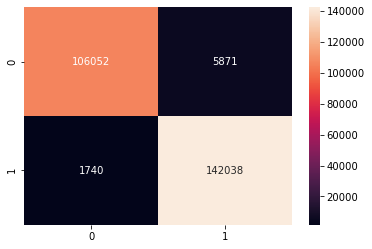

In [37]:
sns.heatmap(cf_matrix, annot=True, fmt='g')

<AxesSubplot:>

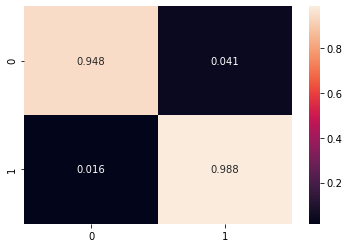

In [38]:
sns.heatmap(cf_matrix / cf_matrix.astype(np.float).sum(axis=1), annot=True, fmt='.3f')

In [39]:
matthews_corrcoef(true_labels, predictions_labels)  

0.939793270569014

In [40]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions_labels)
auc(fpr, tpr)

0.967721151638041

In [41]:
average_precision_score(true_labels, predictions_labels)

0.9554898755459962

In [42]:
precision_recall_fscore_support(true_labels, predictions_labels, average=None)

(array([0.9838578 , 0.96030668]),
 array([0.94754429, 0.98789801]),
 array([0.96535967, 0.97390696]),
 array([111923, 143778], dtype=int64))